In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

## Simple tests

First signalling game. Simple, states and messages are integers.

The scenario is that of a two players signalling game with an environment (The Nature) that selects a state. Given the state, Alice chooses a message and when Bob receives it he selects an action. In case Bob performs the action that matches the state chosen by nature, the cooperation game is a success otherwise it is a failure.

The game is characterized by:

 - the number of states $S$ available to Nature;
 - the number of messages $M$ available to Alice;
 - the number of actions $A$ available to Bob.

States, messages and actions are represented by vectors of positive or null weights that are to be normalized before sampling. Since the weights are positive, one can normalize them straightforwardly: $$w_i = \frac{w_i}{\sum_{j=1}^k w_j}$$ for a vector $\mathbf{w}$ with length $k$.

In [3]:
class SignallingGame:

    def __init__(self, states: int, messages: int, actions: int, seed: int = 42):
        self.states = states
        self.messages = messages
        self.actions = actions
        self.message_weights = np.full((states, messages), 1e-6, dtype=float)
        self.action_weights = np.full((messages, actions), 1e-6, dtype=float)
        self.rng = np.random.RandomState(seed)
        self.stats = []


    def world_state(self):
        return self.rng.randint(self.states)


    def emit_message(self, state):
        w = self.message_weights[state, :]
        probs = w / np.sum(w)
        message = self.rng.choice(self.messages, p=probs)
        return message


    def perform_action(self, message):
        w = self.action_weights[message, :]
        probs = w / np.sum(w)
        action = self.rng.choice(self.actions, p=probs)
        return action


    def payoff(self, state, action):
        return 1 if action == state else 0


    def update_weights(self, state, message, action, payoff):
        self.message_weights[state, message] += payoff
        self.action_weights[message, action] += payoff


    def export_weights(self):
        return self.message_weights.copy(), self.action_weights.copy()


    def snapshot(self, state, message, action, payoff):
        mw, aw = self.export_weights()
        self.stats.append({
            "s": state,
            "m": message,
            "a": action,
            "p": payoff,
            "mw": mw,
            "aw": aw,
        })


    def play(self, N: int):
        for _ in range(N):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)
            self.update_weights(state, message, action, payoff)
            self.snapshot(state, message, action, payoff)

In [4]:
def quick_look(game):
    payoffs = [x["p"] for x in game.stats]
    print("Number of rounds:", len(payoffs))
    print("First 50 payoffs:", payoffs[:50])
    print("Last 50 payoffs:", payoffs[-50:])
    print(f"Success rate: {sum(payoffs)/len(payoffs)*100:.2f}%")

In [5]:
game1 = SignallingGame(states=3, messages=3, actions=3)
game1.play(1000)
quick_look(game1)

Number of rounds: 1000
First 50 payoffs: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 50 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 98.20%


Then we simply add the Roth-Erev update algorithm.

Implement a simulation method that plays the game $N$ times and updates the player related vectors using the Roth-Erev update. For a single game the update is the following:

- $w_i = \lambda w_i + u$ if $i$ was chosen;
- $w_i = \lambda w_i$ if $i$ was not chosen;
- $w_i = \lambda w_i$ if $i$ was not sampled in this game;

where $u$ is the payoff and $\lambda \in [0,1]$.

In [6]:
class RothErevGame(SignallingGame):
    def __init__(self, states: int, messages: int, actions: int, l: float, seed: int = 42):
        super().__init__(states, messages, actions, seed)
        self.l = l

    def update_weights(self, state, message, action, payoff):
        self.message_weights[state] *= self.l
        self.message_weights[(state, message)] += payoff
        self.action_weights[message] *= self.l
        self.action_weights[(message, action)] += payoff

In [7]:
game2 = RothErevGame(states=3, messages=3, actions=3, l=0.5)
game2.play(1000)
quick_look(game2)

Number of rounds: 1000
First 50 payoffs: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 50 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 98.20%


Simple update to the original signalling game: just add a minimal version of the reinforce algorithm.

In [8]:
class ReinforcedGame(SignallingGame):
    def __init__(self, states, messages, actions, lr, seed=42):
        super().__init__(states, messages, actions, seed)

        self.message_weights = torch.nn.Parameter(torch.zeros(states, messages))
        self.action_weights = torch.nn.Parameter(torch.zeros(messages, actions))
        self.optimizer = torch.optim.SGD([self.message_weights, self.action_weights], lr=lr)


    def emit_message(self, state):
        with torch.no_grad():
            probs = torch.softmax(self.message_weights[state], dim=-1)
            message = self.rng.choice(self.messages, p=probs.cpu().numpy())
        return message


    def perform_action(self, message):
        with torch.no_grad():
            probs = torch.softmax(self.action_weights[message], dim=-1)
            action = self.rng.choice(self.actions, p=probs.cpu().numpy())
        return action


    def update_weights(self, state, message, action, payoff):
        reward = torch.tensor(float(payoff))

        # Alice
        log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
        loss_m = -reward * log_probs_m

        # Bob
        log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
        loss_a = -reward * log_probs_a

        loss = loss_m + loss_a
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def export_weights(self):
        return (
            self.message_weights.detach().cpu().numpy().copy(),
            self.action_weights.detach().cpu().numpy().copy(),
        )

In [9]:
game3 = ReinforcedGame(states=3, messages=3, actions=3, lr=0.5)
game3.play(1000)
quick_look(game3)

Number of rounds: 1000
First 50 payoffs: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Last 50 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 92.00%


Now to implement the reinforce algorithm in the weights update.

In [10]:
class ReinforcedGameBatch(ReinforcedGame):
    def __init__(self, states, messages, actions, lr, batch_size, seed=42):
        super().__init__(states, messages, actions, lr, seed)
        self.batch_size = batch_size


    def run_batch(self, batch_n: int):
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            state = self.world_state()
            message = self.emit_message(state)
            action = self.perform_action(message)
            payoff = self.payoff(state, action)

            r = torch.tensor(float(payoff))
            log_probs_m = torch.log_softmax(self.message_weights[state], dim=-1)[message]
            log_probs_a = torch.log_softmax(self.action_weights[message], dim=-1)[action]
            batch_loss += -r * (log_probs_m + log_probs_a)
            self.snapshot(state, message, action, payoff)

        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play(self, N: int):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

In [11]:
game4 = ReinforcedGameBatch(states=3, messages=3, actions=3, lr=1, batch_size=1)
game4.play(1000)
quick_look(game4)

Number of rounds: 1000
First 50 payoffs: [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Last 50 payoffs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 95.00%


## Baseline

Now that it works with simple integers, we can try with tuples.

The game context is that of Referential games where Nature shows $K$ pictures to Alice and chooses one of them. Then Alice has to send a message to Bob telling which picture she has seen in the list. Bob sees the list of pictures in the same order and has to guess which one Nature had chosen.

In our case the pictures will be digits from 0 to 9 coloured in red, green, blue or white and of different sizes: small, medium and large. (You are free to add different properties if you like).

We consider that each picture is represented by a tuple $(D,C,S)$ where $D$ is the digit value, $C$ the color and $S$ the size of the digit.

The symbolic game is made of 2 agents (Alice and Bob) and one environment (Nature). Nature shows $K$ pictures to Alice and selects one. Alice sends a message to Bob and this is a single symbol taken from a finite set $M$ of messages in this baseline. By design you may wish to structure the symbol as a tuple of 3 features to ease interpretation.

:::{.callout-note}
## Instructions

Implement this game with the reinforce algorithm. Implement the relevant analysis tools to analyze the game simulation (convergence, average reward...). Try to interpret the resulting model. Is it possible to interpret the agents weight and interpret their strategies? Can you interpret the content of the messages sent? You may either try to design/constrain the model a priori to make interpretation easy or try to analyze it post-hoc. Write at least 20 lines explaining what you did, what experiments and statistics you collect to interpret the simulation and what you conclude from your observations.
:::

In [12]:
class SymbolicReinforcedGame():
    def __init__(self, K=3, state_dims=(10, 4, 3), lr=0.1, batch_size=20, seed=42):
        self.K = K
        self.state_dims = state_dims
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.total_states = np.prod(state_dims)
        self.stats = []

        # Alice's weights - separate matrix for each message component
        self.message_color_weights = torch.nn.Parameter(torch.zeros(state_dims[0], state_dims[0]))
        self.message_shape_weights = torch.nn.Parameter(torch.zeros(state_dims[1], state_dims[1]))
        self.message_size_weights = torch.nn.Parameter(torch.zeros(state_dims[2], state_dims[2]))

        # Bob's weights - separate matrix for each action component
        self.action_color_weights = torch.nn.Parameter(torch.zeros(state_dims[0], state_dims[0]))
        self.action_shape_weights = torch.nn.Parameter(torch.zeros(state_dims[1], state_dims[1]))
        self.action_size_weights = torch.nn.Parameter(torch.zeros(state_dims[2], state_dims[2]))

        # Optimizer
        self.optimizer = torch.optim.SGD([
            self.message_color_weights,
            self.message_shape_weights,
            self.message_size_weights,
            self.action_color_weights,
            self.action_shape_weights,
            self.action_size_weights,
        ], lr=lr)


    def world_state(self):
        state = []
        for _ in range(self.K):
            color = self.rng.randint(self.state_dims[0])
            shape = self.rng.randint(self.state_dims[1])
            size = self.rng.randint(self.state_dims[2])
            state.append((color, shape, size))

        target_index = self.rng.randint(self.K)
        return state, target_index


    def emit_message(self, state, target_index):
        target = state[target_index]
        with torch.no_grad():
            color_probs = torch.softmax(self.message_color_weights[target[0]], dim=-1)
            shape_probs = torch.softmax(self.message_shape_weights[target[1]], dim=-1)
            size_probs = torch.softmax(self.message_size_weights[target[2]], dim=-1)

            color = self.rng.choice(self.state_dims[0], p=color_probs.cpu().numpy())
            shape = self.rng.choice(self.state_dims[1], p=shape_probs.cpu().numpy())
            size = self.rng.choice(self.state_dims[2], p=size_probs.cpu().numpy())

        message = (color, shape, size)
        return message


    def perform_action(self, message, state):
        with torch.no_grad():
            scores = []
            for obj in state:
                # For each object, compute compatibility with message
                color_score = self.action_color_weights[message[0], obj[0]]
                shape_score = self.action_shape_weights[message[1], obj[1]]
                size_score = self.action_size_weights[message[2], obj[2]]

                total_score = color_score + shape_score + size_score
                scores.append(total_score)

            scores = torch.stack(scores)
            probs = torch.softmax(scores, dim=-1)
            action = self.rng.choice(self.K, p=probs.cpu().numpy())
        return action


    def payoff(self, target_index, action):
        return 1 if action == target_index else 0


    def update_weights(self, state, target_index, message, action, payoff):
        reward = torch.tensor(float(payoff))
        target = state[target_index]

        # Alice's log probabilities for each feature
        log_probs_color = torch.log_softmax(self.message_color_weights[target[0]], dim=-1)[message[0]]
        log_probs_shape = torch.log_softmax(self.message_shape_weights[target[1]], dim=-1)[message[1]]
        log_probs_size = torch.log_softmax(self.message_size_weights[target[2]], dim=-1)[message[2]]

        # Alice's loss
        loss_alice = -reward * (log_probs_color + log_probs_shape + log_probs_size)

        # Bob's log probabilities for choosing the action
        # Need to recompute scores for all K objects
        scores = []
        for obj in state:
            color_score = self.action_color_weights[message[0], obj[0]]
            shape_score = self.action_shape_weights[message[1], obj[1]]
            size_score = self.action_size_weights[message[2], obj[2]]
            total_score = color_score + shape_score + size_score
            scores.append(total_score)

        scores = torch.stack(scores)
        log_probs_action = torch.log_softmax(scores, dim=-1)[action]

        # Bob's loss
        loss_bob = -reward * log_probs_action

        # Combined loss
        loss = loss_alice + loss_bob
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def run_batch(self, batch_n: int):
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            state, target_index = self.world_state()
            message = self.emit_message(state, target_index)
            action = self.perform_action(message, state)
            payoff = self.payoff(target_index, action)
            self.snapshot(state, target_index, message, action, payoff)

            reward = torch.tensor(float(payoff))
            target = state[target_index]

            # Alice's log probabilities for each feature
            log_probs_color = torch.log_softmax(self.message_color_weights[target[0]], dim=-1)[message[0]]
            log_probs_shape = torch.log_softmax(self.message_shape_weights[target[1]], dim=-1)[message[1]]
            log_probs_size = torch.log_softmax(self.message_size_weights[target[2]], dim=-1)[message[2]]

            # Bob's log probabilities for choosing the target
            scores = []
            for obj in state:
                color_score = self.action_color_weights[message[0], obj[0]]
                shape_score = self.action_shape_weights[message[1], obj[1]]
                size_score = self.action_size_weights[message[2], obj[2]]
                total_score = color_score + shape_score + size_score
                scores.append(total_score)
            scores = torch.stack(scores)
            log_probs_action = torch.log_softmax(scores, dim=-1)[action]

            # Losses
            loss_alice = log_probs_color + log_probs_shape + log_probs_size
            loss_bob = log_probs_action
            batch_loss += -reward * (loss_alice + loss_bob)

        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)


    def play(self, N):
        for _ in range(N):
            state, target_index = self.world_state()
            message = self.emit_message(state, target_index)
            action = self.perform_action(message, state)
            payoff = self.payoff(target_index, action)
            self.snapshot(state, target_index, message, action, payoff)
            self.update_weights(state, target_index, message, action, payoff)


    def snapshot(self, state, target_index, message, action, payoff):
        msg_strat, act_strat = self.export_strategies()

        self.stats.append({
            "state": state,
            "target_index": target_index,
            "m": message,
            "a": action,
            "p": payoff,
            "msg_strategies": msg_strat,
            "act_strategies": act_strat,
        })


    def export_strategies(self):
        with torch.no_grad():
            # Messaging strategies: for each state feature, what message to send?
            message_strategies = {
                'digit': torch.softmax(self.message_color_weights, dim=-1).cpu().numpy(),  # (10, 10)
                'color': torch.softmax(self.message_shape_weights, dim=-1).cpu().numpy(),  # (4, 4)
                'size': torch.softmax(self.message_size_weights, dim=-1).cpu().numpy(),    # (3, 3)
            }

            # Action strategies: for each message feature, what object feature to choose?
            action_strategies = {
                'digit': torch.softmax(self.action_color_weights, dim=-1).cpu().numpy(),  # (10, 10)
                'color': torch.softmax(self.action_shape_weights, dim=-1).cpu().numpy(),  # (4, 4)
                'size': torch.softmax(self.action_size_weights, dim=-1).cpu().numpy(),    # (3, 3)
            }

            return message_strategies, action_strategies

In [13]:
game5 = SymbolicReinforcedGame(K=3, lr=0.5, batch_size=20)
game5.play_batch(100000)
quick_look(game5)

Number of rounds: 100000
First 50 payoffs: [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Last 50 payoffs: [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Success rate: 87.36%


In [14]:
def plot_strategy_evolution(game, feature='digit', agent='message'):
    # Get number of features for this dimension
    feature_to_dim = {'digit': 0, 'color': 1, 'size': 2}
    num_features = game.state_dims[feature_to_dim[feature]]
    
    # Setup subplot grid (always 2 columns)
    ncols = 2
    nrows = (num_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    axes = np.atleast_1d(axes).flatten()
    
    # Extract strategy key
    strategy_key = 'msg_strategies' if agent == 'message' else 'act_strategies'
    
    # Plot each state
    for state_idx in range(num_features):
        # Collect probability trajectories
        trajectories = [[] for _ in range(num_features)]
        
        for stat in game.stats:
            strategy = stat[strategy_key][feature]
            for option_idx in range(num_features):
                trajectories[option_idx].append(strategy[state_idx, option_idx])
        
        # Plot trajectories
        ax = axes[state_idx]
        label_prefix = 'm' if agent == 'message' else 'a'
        for option_idx, trajectory in enumerate(trajectories):
            ax.plot(trajectory, label=f'{label_prefix}{option_idx}')
        
        ax.set_title(f'State {state_idx}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Strategy Weights')
        ax.set_ylim([0, 1])
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_features, len(axes)):
        axes[idx].axis('off')
    
    # Add title
    agent_name = 'Messaging' if agent == 'message' else 'Action'
    condition = 'Nature' if agent == 'message' else 'Messaging'
    fig.suptitle(f'{agent_name} Strategies Given {condition} State ({feature}s)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

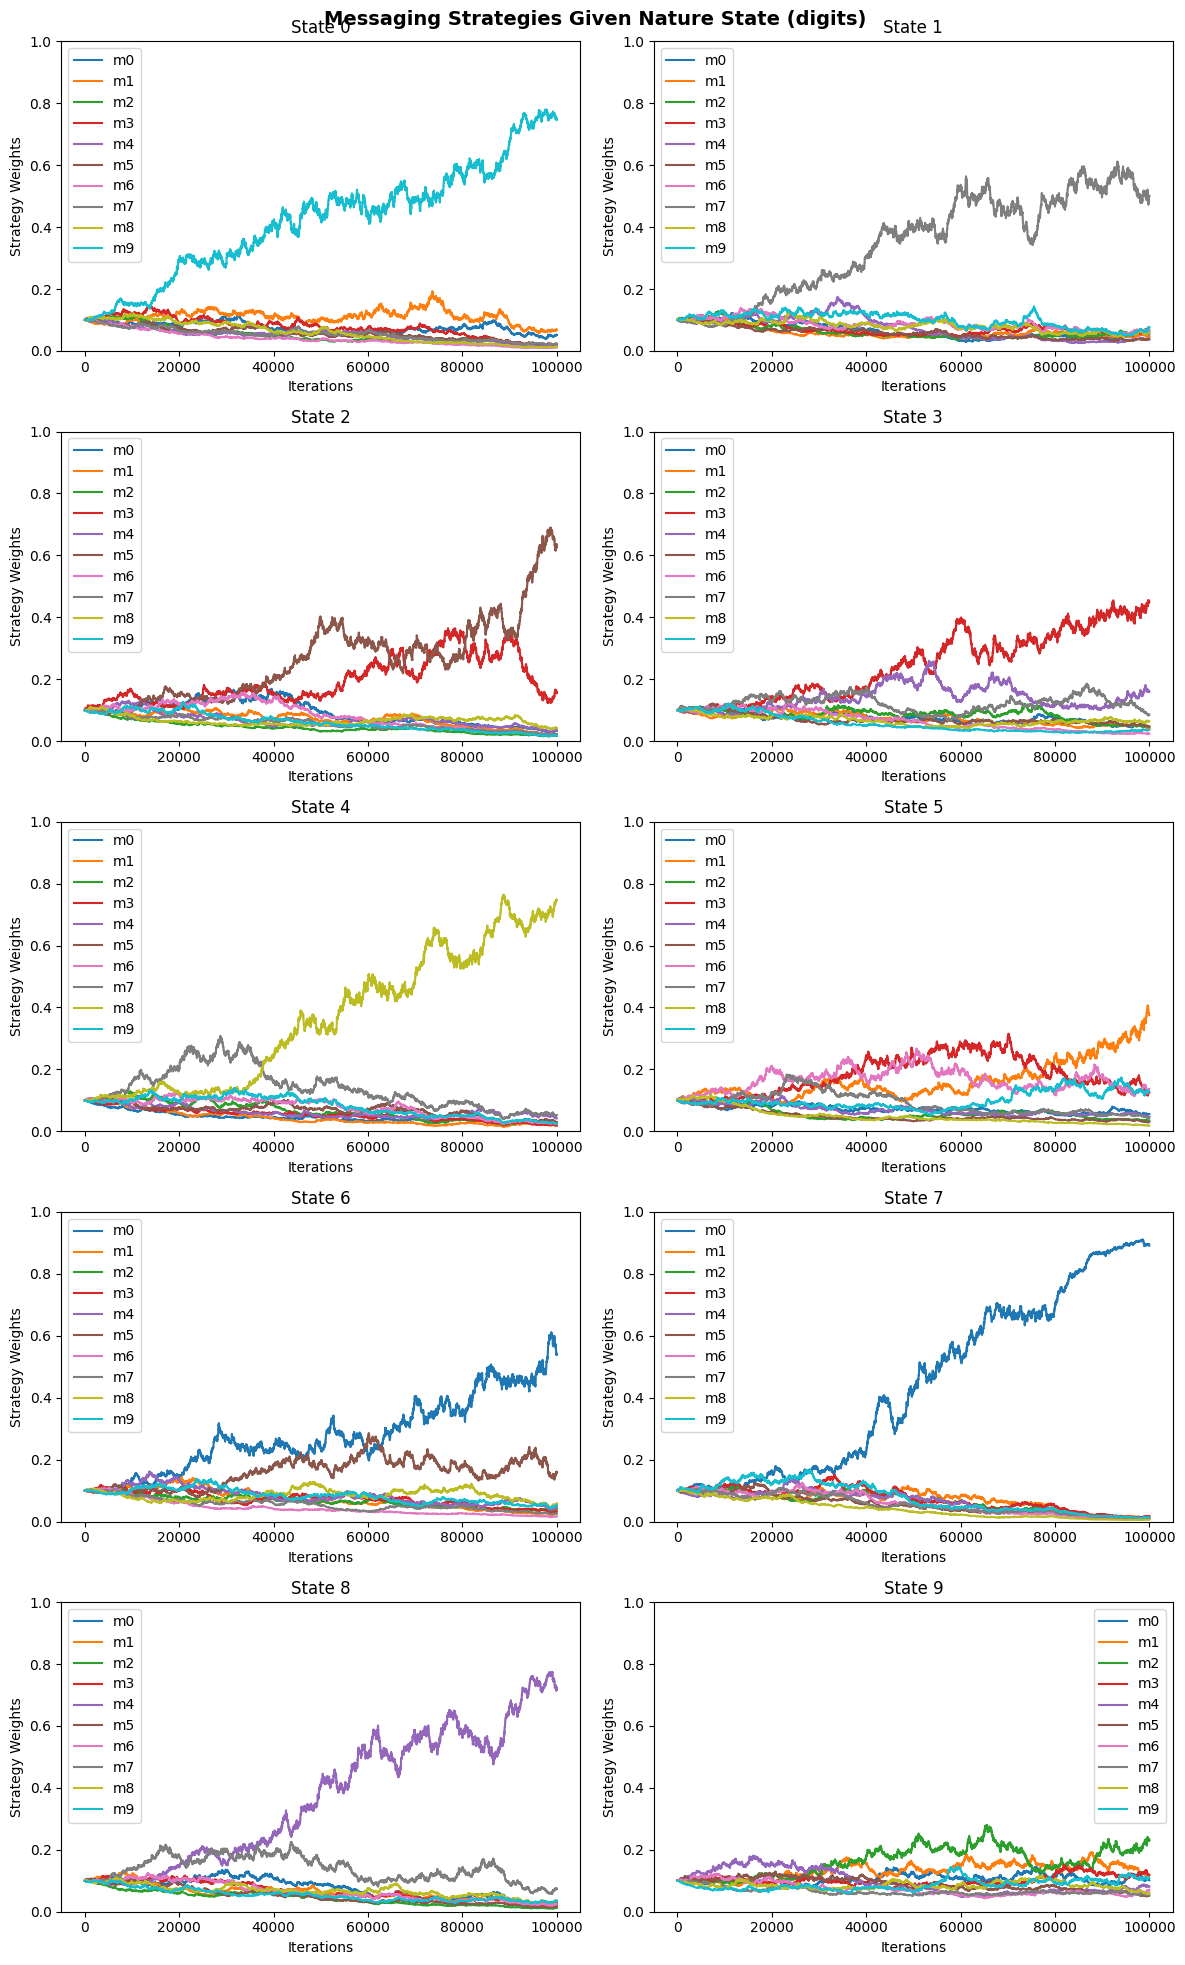

In [15]:
plot_strategy_evolution(game5, feature='digit', agent='message')

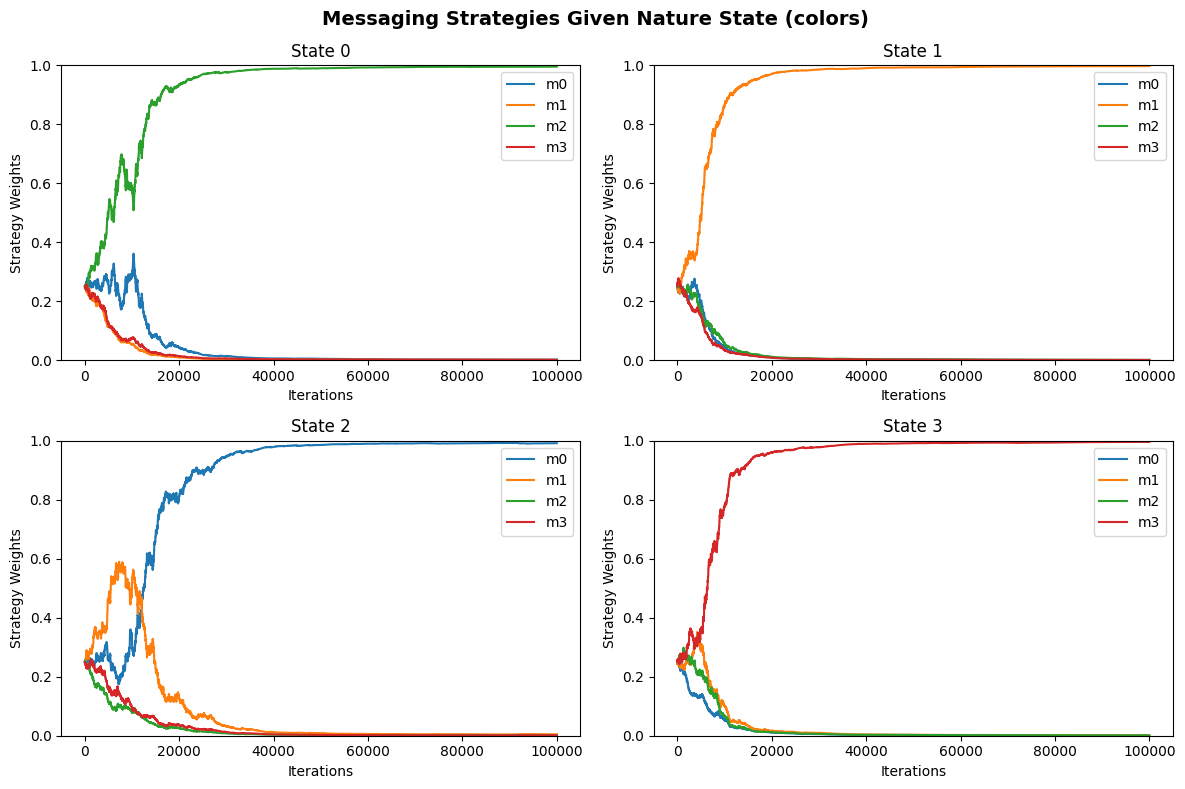

In [16]:
plot_strategy_evolution(game5, feature='color', agent='message')

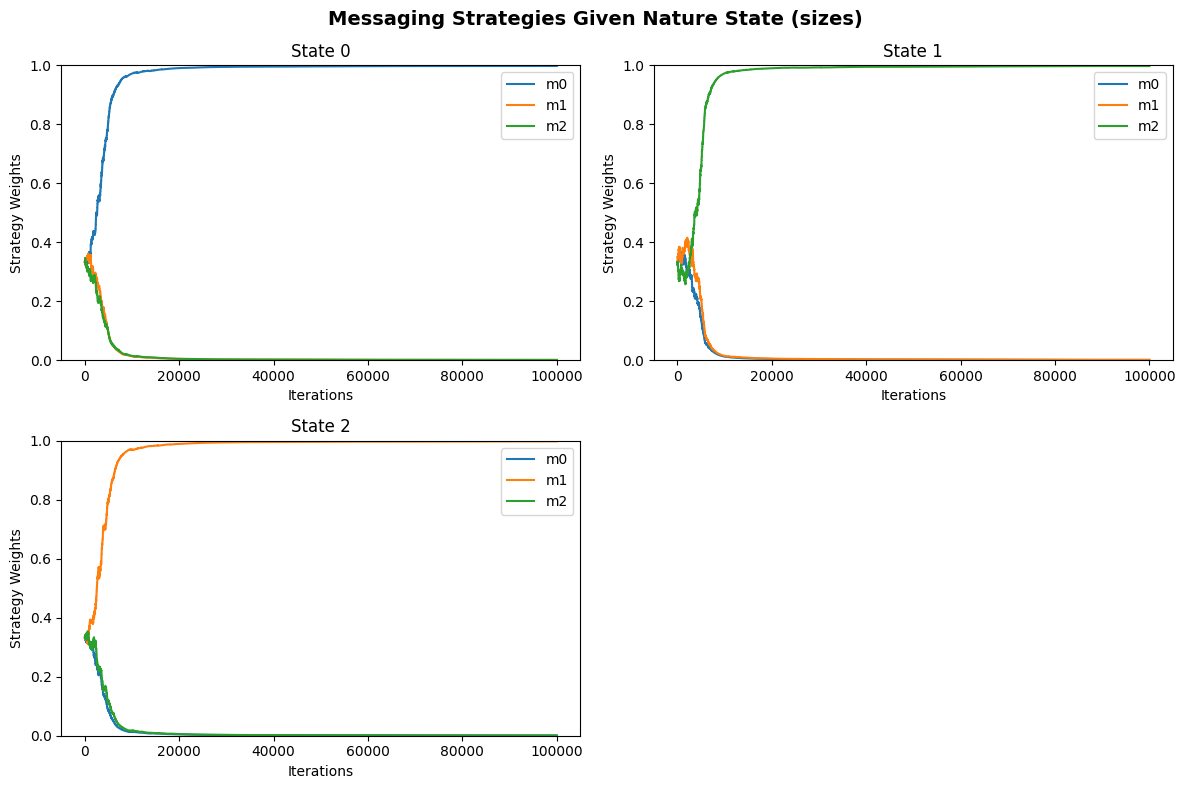

In [17]:
plot_strategy_evolution(game5, feature='size', agent='message')

Commentaires ici.

## Extended baseline with LSTM

:::{.callout-note}
## Instructions

This is the same exercise as the previous one. This time the message is a sequence of symbols generated by an LSTM language model. Alice generates a string and Bob has to encode it in a vector. You may limit the maximum size of the message. Explain whether you can interpret the messages. Design experiments to get explanations. Explain what you did and to which extent you can interpret the generated language.
:::

In [18]:
class SymbolicLSTMGame(nn.Module):
    def __init__(self, K=3, state_dims=(10, 4, 3), vocab_size=17, hidden_size=30, max_length=3, lr=0.001, batch_size=20, seed=42):
        super().__init__()

        # Game parameters
        self.K = K
        self.state_dims = state_dims
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.stats = []

        # Dedicated start token index
        self.start_token = 0 # Using token 0 as a dedicated start token

        # Alice's architecture
        self.alice_color_emb = nn.Embedding(state_dims[0], hidden_size // 3)
        self.alice_shape_emb = nn.Embedding(state_dims[1], hidden_size // 3)
        self.alice_size_emb = nn.Embedding(state_dims[2], hidden_size // 3)
        self.alice_token_emb = nn.Embedding(vocab_size, hidden_size)
        self.alice_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.alice_output = nn.Linear(hidden_size, vocab_size)

        # Bob's architecture
        self.bob_color_emb = nn.Embedding(state_dims[0], hidden_size // 3)
        self.bob_shape_emb = nn.Embedding(state_dims[1], hidden_size // 3)
        self.bob_size_emb = nn.Embedding(state_dims[2], hidden_size // 3)
        self.bob_token_emb = nn.Embedding(vocab_size, hidden_size)
        self.bob_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.bob_output = nn.Linear(hidden_size * 2, 1)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)


    def world_state(self):
        state = []
        for _ in range(self.K):
            color = self.rng.randint(self.state_dims[0])
            shape = self.rng.randint(self.state_dims[1])
            size = self.rng.randint(self.state_dims[2])
            state.append((color, shape, size))

        target_index = self.rng.randint(self.K)
        return state, target_index


    def emit_message(self, state, target_index):
        target = state[target_index]

        # Encode the target object
        color_vec = self.alice_color_emb(torch.tensor(target[0]))
        shape_vec = self.alice_shape_emb(torch.tensor(target[1]))
        size_vec = self.alice_size_emb(torch.tensor(target[2]))
        target_encoding = torch.cat([color_vec, shape_vec, size_vec])

        # Initialize LSTM hidden state with target encoding
        h = target_encoding.unsqueeze(0).unsqueeze(0) # (1, 1, hidden_size)
        c = torch.zeros_like(h)
        hidden = (h, c)

        # Generate sequence
        sequence = []
        log_probs_alice = []
        # Start with a learned start token embedding
        current_input_emb = self.alice_token_emb(torch.tensor([self.start_token])).unsqueeze(1)

        # Generate tokens auto-regressively
        for _ in range(self.max_length):
            output, hidden = self.alice_lstm(current_input_emb, hidden)

            logits = self.alice_output(output.squeeze(1))
            # Use Categorical distribution for sampling and getting log_prob
            dist = torch.distributions.Categorical(logits=logits)
            token = dist.sample()
            log_probs_alice.append(dist.log_prob(token))

            sequence.append(token.item())
            # FIX: Remove extra unsqueeze(0) on token, as token already has batch dimension
            current_input_emb = self.alice_token_emb(token).unsqueeze(1)

        return tuple(sequence), torch.sum(torch.stack(log_probs_alice))


    def perform_action(self, message, state):
        # Encode Alice's message sequence
        message_tensor = torch.tensor(message) # (max_length,)
        message_emb = self.bob_token_emb(message_tensor) # (max_length, hidden_size)
        message_emb = message_emb.unsqueeze(0) # (1, max_length, hidden_size)

        # Run through LSTM encoder
        _, (h_final, _) = self.bob_lstm(message_emb) # h_final: (1, 1, hidden_size)
        message_encoding = h_final.squeeze() # (hidden_size,)

        # Score each of the K objects
        scores = []
        for obj in state:
            # Encode object
            color_vec = self.bob_color_emb(torch.tensor(obj[0]))
            shape_vec = self.bob_shape_emb(torch.tensor(obj[1]))
            size_vec = self.bob_size_emb(torch.tensor(obj[2]))
            object_encoding = torch.cat([color_vec, shape_vec, size_vec]) # (hidden_size,)

            # Compute compatibility score between message and object
            combined = torch.cat([message_encoding, object_encoding])  # (hidden_size * 2,)
            score = self.bob_output(combined) # (1,)
            scores.append(score)

        # Choose action based on scores
        scores = torch.stack(scores).squeeze() # (K,)
        dist = torch.distributions.Categorical(logits=scores)
        action = dist.sample()
        log_probs_action = dist.log_prob(action)

        return action.item(), log_probs_action

    def payoff(self, target_index, action):
        return 1 if action == target_index else 0


    def update_weights(self, state, target_index, message, action, payoff):
        # This method is not used by play_batch, but keeping it updated for consistency if 'play' is used.
        reward = torch.tensor(float(payoff))
        target = state[target_index]

        # ALICE'S LOSS
        # Recompute Alice's generation WITH GRADIENTS

        # Encode target
        color_vec = self.alice_color_emb(torch.tensor(target[0]))
        shape_vec = self.alice_shape_emb(torch.tensor(target[1]))
        size_vec = self.alice_size_emb(torch.tensor(target[2]))
        target_encoding = torch.cat([color_vec, shape_vec, size_vec])

        # Initialize decoder
        h = target_encoding.unsqueeze(0).unsqueeze(0) # (1, 1, hidden_size)
        c = torch.zeros_like(h)
        hidden = (h, c)

        # Recompute generation for the tokens Alice actually produced
        log_probs_alice_list = [] # Renamed to avoid conflict
        current_input_emb = self.alice_token_emb(torch.tensor([self.start_token])).unsqueeze(1)

        for t in range(self.max_length):
            output, hidden = self.alice_lstm(current_input_emb, hidden)
            logits = self.alice_output(output.squeeze(1))
            dist = torch.distributions.Categorical(logits=logits)

            # Get log probability of the token Alice actually generated
            # FIX: unsqueeze(0) for scalar message[t] to match dist.batch_shape
            log_probs_t = dist.log_prob(torch.tensor(message[t]).unsqueeze(0))
            log_probs_alice_list.append(log_probs_t)

            # Next input is the token Alice actually generated (not sampled)
            current_input_emb = self.alice_token_emb(torch.tensor([message[t]])).unsqueeze(1)

        # Sum all log probabilities
        total_log_probs_alice = torch.sum(torch.stack(log_probs_alice_list))
        loss_alice = -reward * total_log_probs_alice

        # BOB'S LOSS
        # Recompute Bob's decision WITH GRADIENTS

        # Encode message
        message_tensor = torch.tensor(message)
        message_emb = self.bob_token_emb(message_tensor).unsqueeze(0)
        _, (h_final, _) = self.bob_lstm(message_emb)
        message_encoding = h_final.squeeze()

        # Score each object
        scores = []
        for obj in state:
            color_vec = self.bob_color_emb(torch.tensor(obj[0]))
            shape_vec = self.bob_shape_emb(torch.tensor(obj[1]))
            size_vec = self.bob_size_emb(torch.tensor(obj[2]))
            object_encoding = torch.cat([color_vec, shape_vec, size_vec])

            combined = torch.cat([message_encoding, object_encoding])
            score = self.bob_output(combined)
            scores.append(score)

        scores = torch.stack(scores).squeeze()
        dist_bob = torch.distributions.Categorical(logits=scores)
        log_prob_action = dist_bob.log_prob(torch.tensor(action))

        loss_bob = -reward * log_prob_action

        # COMBINED UPDATE
        loss = loss_alice + loss_bob

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def run_batch(self, batch_n):
        """
        Play batch_n games and update weights once at the end.
        """
        self.optimizer.zero_grad()
        batch_loss = torch.tensor(0.0)

        for _ in range(batch_n):
            # Play one game
            state, target_index = self.world_state()
            message, log_prob_A_val = self.emit_message(state, target_index) # Renamed to avoid name clash with `dist`
            action, log_prob_B = self.perform_action(message, state)
            payoff = self.payoff(target_index, action)

            # Accumulate loss for the batch using the log-probabilities with gradients
            reward = torch.tensor(float(payoff))

            # Recompute log_prob_A with gradients to correctly apply REINFORCE
            target = state[target_index]

            # Encode the target object
            color_vec = self.alice_color_emb(torch.tensor(target[0]))
            shape_vec = self.alice_shape_emb(torch.tensor(target[1]))
            size_vec = self.alice_size_emb(torch.tensor(target[2]))
            target_encoding = torch.cat([color_vec, shape_vec, size_vec])

            # Initialize LSTM hidden state with target encoding
            h = target_encoding.unsqueeze(0).unsqueeze(0)
            c = torch.zeros_like(h)
            hidden = (h, c)

            log_probs_alice_list_grad = []
            current_input_emb_grad = self.alice_token_emb(torch.tensor([self.start_token])).unsqueeze(1)

            for t in range(self.max_length):
                output, hidden = self.alice_lstm(current_input_emb_grad, hidden)
                logits_grad = self.alice_output(output.squeeze(1))
                dist_grad = torch.distributions.Categorical(logits=logits_grad)
                # FIX: unsqueeze(0) for scalar message[t] to match dist_grad.batch_shape
                log_probs_alice_list_grad.append(dist_grad.log_prob(torch.tensor(message[t]).unsqueeze(0)))
                current_input_emb_grad = self.alice_token_emb(torch.tensor([message[t]])).unsqueeze(1)

            log_prob_A = torch.sum(torch.stack(log_probs_alice_list_grad))

            # REINFORCE loss: sum of log_probs of sampled actions, scaled by reward
            batch_loss += -reward * (log_prob_A + log_prob_B)

        # Single update for the whole batch
        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

    def play(self, N):
        for _ in range(N):
            state, target_index = self.world_state()
            message = self.emit_message(state, target_index)
            action = self.perform_action(message, state)
            payoff = self.payoff(target_index, action)

In [19]:
# game6 = SymbolicLSTMGame(K=3, batch_size=100, lr=0.1, hidden_size=15, max_length=3, vocab_size=10)
# game6.play_batch(50000)
# quick_look(game6)

## Referential game with images

Try the signalling game with real images!

### Download the MNIST dataset

First example: (<PIL.Image.Image image mode=L size=28x28 at 0x322279400>, 5), an object of <class 'tuple'>.


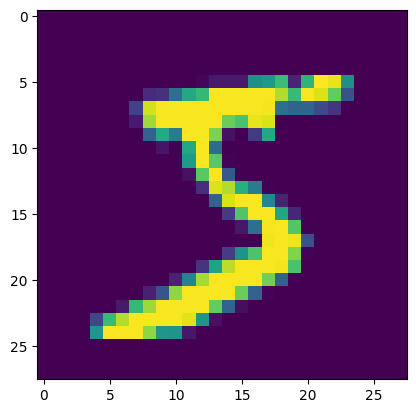

In [20]:
from torchvision.datasets import MNIST

dataset = MNIST("data", download=True)
print(f"First example: {dataset[0]}, an object of {type(dataset[0])}.")
plt.imshow(dataset[0][0])
plt.show()

Turn the image to a standard torch tensor.

In [21]:
from torchvision.transforms.functional import pil_to_tensor

img_tensor = pil_to_tensor(dataset[0][0])
print(img_tensor.shape)

torch.Size([1, 28, 28])


Helper functions to create images of different sizes and colors.

In [22]:
from torchvision.transforms import Pad, Resize

def scale_transform(image_tensor, scale_code):
    """
    Scale image by padding and resizing.
    scale_code: 0 for original size, 1 for small, 2 for very small
    """
    padded = Pad(10 * scale_code, fill=0)(image_tensor)
    scaled = Resize((28, 28))(padded)
    return scaled


def color_transform(image_tensor, color_code):
    """
    Convert grayscale image to coloured RGB image.
    color_code: Color channel - "red", "green", or "blue"
    """
    coloured = torch.zeros((3, 28, 28), dtype=torch.float32)

    color_channels = {
        "red": 0,
        "green": 1,
        "blue": 2
    }

    if color_code not in color_channels:
        raise ValueError(f"Invalid color code: {color_code}. Must be 'red', 'green', or 'blue'")

    coloured[color_channels[color_code]] = image_tensor
    return coloured


def color_scale(image_tensor, color_code="green", scale_code=0):
    """
    Apply color transformation followed by scaling.
    color_code: Color channel - "red", "green", or "blue" (default: "green")
    scale_code: 0 for original size, 1 for small, 2 for very small (default: 0)
    """
    return scale_transform(color_transform(image_tensor, color_code), scale_code)

Create a randomized dataset.

In [23]:
import random
from torchvision.transforms import ToTensor

# Configuration
COLORS = ["red", "green", "blue"]
SIZES = [0, 1, 2]
labels = []
def randomize_tensorize_img(img_label_pair):
    img = ToTensor()(img_label_pair[0])
    color = random.choice(COLORS)
    size = random.choice(SIZES)
    labels.append((img_label_pair[1], color, size))
    return color_scale(img, color_code=color, scale_code=size)

# Transform entire dataset: random colors and sizes
mnist_colors = torch.stack([randomize_tensorize_img(item) for item in dataset])

### Autoencoder

Now to build an auto-encoder.

To get an image vector, we will use a primitive method for encoding the images. First we get a raw vector by flattening the image matrices (one matrix for each channel) and then these three vectors are concatenated.

Then we perform dimension reduction by using a simple auto-encoder. An auto-encoder is a neural network whose task it to predict its input. The key feature is that the auto-encoder maps the input to a low dimension vector and then maps this low dimension representation again to the input dimension. In its simplest form it takes the form of a feed-forward network trained with an MSE loss.

In [24]:
from tqdm import tqdm


class MNISTAutoencoder(nn.Module):
    """
    Autoencoder for MNIST images with color channels.
    Encodes flattened RGB images (3*28*28 = 2352 dims) to a lower dimensional
    latent representation and reconstructs the original image.
    """


    def __init__(self, input_dim=2352, latent_dim=64):
        """
        input_dim: Flattened image dimension (default: 28*28*3 = 2352)
        latent_dim: Dimension of latent representation
        """
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder: input_dim -> 128 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder: latent_dim -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output in [0, 1] range
        )


    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


    def encode(self, image):
        """
        image: Tensor of shape (3, 28, 28) or batch (N, 3, 28, 28)
        Returns: latent representation tensor
        """
        # Handle single image or batch
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add batch dimension

        # Flatten to (batch_size, input_dim)
        flattened = image.reshape(-1, self.input_dim)

        with torch.no_grad():
            encoded = self.encoder(flattened)

        return encoded.squeeze(0) if encoded.size(0) == 1 else encoded


    def train_autoencoder(self, dataset, batch_size=64, epochs=10, lr=1e-3, device="cpu"):
        """
        dataset: Tensor of images, shape (N, 3, 28, 28)
        batch_size: Number of samples per batch
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on ('cpu' or 'cuda')
        """
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        n_batches = len(dataset) // batch_size

        # Progress bar for batches
        progress_bar = tqdm(range(epochs), desc=f"Training over {epochs} epochs")

        for _ in progress_bar:
            self.train()  # Set to training mode
            total_loss = 0.0

            for batch_idx in range(n_batches):
                # Get batch and flatten
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch = dataset[start_idx:end_idx]
                x = batch.reshape(-1, self.input_dim).to(device)

                # Forward pass
                optimizer.zero_grad()
                x_reconstructed = self.forward(x)
                loss = criterion(x_reconstructed, x)

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * x.size(0)

            # Print epoch statistics
            avg_loss = total_loss / (n_batches * batch_size)
            progress_bar.set_postfix({'loss': f'{avg_loss:.6f}'})


    def save_model(self, filename):
        torch.save(self.state_dict(), filename)


    def load_model(self, filename, device="cpu"):
        self.load_state_dict(torch.load(filename, map_location=device))
        self.eval()  # Set to evaluation mode

In [25]:
autoencoder_64 = MNISTAutoencoder(input_dim=2352, latent_dim=64)
autoencoder_64.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it, loss=0.001374]


In [26]:
autoencoder_128 = MNISTAutoencoder(input_dim=2352, latent_dim=128)
autoencoder_128.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it, loss=0.001176]


In [27]:
autoencoder_256 = MNISTAutoencoder(input_dim=2352, latent_dim=256)
autoencoder_256.train_autoencoder(mnist_colors, batch_size=64, epochs=10)

Training over 10 epochs: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, loss=0.001087]


### The game

In [28]:
class ReferentialGame(nn.Module):
    """
    A two-agent referential signalling game trained with REINFORCE.
    Alice (Sender) observes the target picture and emits a discrete message.
    Bob (Receiver) observes the message and all pictures and selects a picture.
    Both agents are rewarded if Bob selects the correct target.
    """
    def __init__(
        self,
        K: int,
        dataset_pictures: torch.Tensor,
        autoencoder: MNISTAutoencoder,
        thinking_dim = 16,
        lr: float = 0.1,
        batch_size: int = 20,
        seed: int = 1971,
    ):
        super().__init__()
        self.K = K
        self.dataset_pictures = dataset_pictures
        self.batch_size = batch_size
        self.thinking_dim = thinking_dim
        self.input_dim = autoencoder.latent_dim
        self.autoencoder = autoencoder
        self.rng = np.random.RandomState(seed)
        self.stats = []

        # --- Alice: policy π_A(m | target picture)
        # Gaussian policy parameters (mean and log-std) for message generation
        self.alice_mu = nn.Linear(self.input_dim, self.thinking_dim)
        self.alice_log_std = nn.Linear(self.input_dim, self.thinking_dim)

        # --- Bob: policy π_B(i | m, pictures) over i in {0..K-1}
        # "Embeddings" for received message symbols
        self.bob_emb = torch.nn.Linear(self.thinking_dim, self.input_dim)

        # Optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)


    def world_state(self):
        pictures_id = self.rng.choice(len(self.dataset_pictures), self.K, replace=False)
        target = self.rng.randint(self.K)
        return pictures_id, target


    def emit_message(self, pictures, target):
        target_repr = pictures[target]

        # Gaussian policy parameters
        mu = self.alice_mu(target_repr) # (thinking_dim,)
        mu = torch.tanh(mu)

        log_std = self.alice_log_std(target_repr) # (thinking_dim,)
        log_std = torch.clamp(log_std, min=-5.0, max=5.0)
        std = torch.exp(log_std)

        # Policy distribution
        dist_alice = torch.distributions.Normal(mu, std)

        # Sample message
        message = dist_alice.rsample()

        # Log-probability of sampled message
        log_prob_alice = dist_alice.log_prob(message).sum(dim=-1)

        return message, log_prob_alice


    def perform_action(self, pictures, message):
        message_understood = self.bob_emb(message) # thinking_dim -> input_dim

        # Compute scores for each picture
        scores = []
        scores = [torch.dot(p, message_understood) for p in pictures]
        scores = torch.stack(scores) # (K,)
        dist_bob = torch.distributions.Categorical(logits=scores)

        # Sample chosen picture
        chosen_pic = dist_bob.sample()

        # Log-probability of sampled picture
        log_prob_bob = dist_bob.log_prob(chosen_pic)

        return chosen_pic.item(), log_prob_bob


    def payoff(self, target, action):
        return 1 if action == target else 0


    def run_batch(self, batch_n: int):
        """
        For each episode in the batch:
        1. Raw image (>2000 dimensions) -> Autoencoder -> encoded_image (input_size)
        2. Alice receives encoded_image -> produces message (thinking_size)
        3. Bob receives message -> interprets as message_understood (input_size)
        4. Bob compares message_understood with encoded_image (both input_size)
        """
        self.optimizer.zero_grad()
        batch_loss = torch.zeros(())

        for _ in range(batch_n):
            # Nature selects K pictures and target
            pictures_id, target_id = self.world_state()
            pictures = self.dataset_pictures[pictures_id]
            seen_pictures = self.autoencoder.encode(pictures)

            # Alice emits message based on target picture
            message, log_prob_alice = self.emit_message(seen_pictures, target_id)
            
            # Bob performs action based on message and all pictures
            action, log_prob_bob = self.perform_action(seen_pictures, message)

            # Get reward
            r = float(self.payoff(target_id, action))
            reward = torch.tensor(r, dtype=torch.float32)

            # REINFORCE loss
            loss = -reward * (log_prob_alice + log_prob_bob)
            batch_loss = batch_loss + loss

            self.stats.append({"pics": pictures_id, "t": target_id, "p": int(r), "m": message})

        # Single update for the whole batch
        (batch_loss / batch_n).backward()
        self.optimizer.step()


    def play_batch(self, N):
        num_batches = N // self.batch_size
        remainder = N % self.batch_size

        for _ in range(num_batches):
            self.run_batch(self.batch_size)

        if remainder > 0:
            self.run_batch(remainder)

In [29]:
AUTOENCODER = autoencoder_256
THINKING_DIM = 8
LEARNING_RATE = 0.9
BATCH_SIZE = 100

In [30]:
game7 = ReferentialGame(
    K=3,
    dataset_pictures=mnist_colors,
    autoencoder=AUTOENCODER,
    thinking_dim=THINKING_DIM,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE
)

game7.play_batch(100000)

In [31]:
def longer_look(game, training_steps):
    training_steps = int(training_steps)
    
    payoffs = [x["p"] for x in game.stats]
    answer_labels = [labels[s["pics"][s["t"]]] for s in game.stats]
    
    accuracy = sum(payoffs) / len(payoffs) * 100
    print(f"Overall accuracy: {accuracy:.2f}%")
    
    correct_payoffs = sum(payoffs[training_steps:]) / len(payoffs[training_steps:])
    correct_accuracy = correct_payoffs * 100
    print(f"Accuracy after {training_steps} steps: {correct_accuracy:.2f}%")
    
    # Initialize performance tracking
    performance = {
        'digit': {i: {'correct': 0, 'total': 0} for i in range(10)},
        'color': {color: {'correct': 0, 'total': 0} for color in COLORS},
        'size': {size: {'correct': 0, 'total': 0} for size in SIZES}
    }
    
    # Aggregate results
    for payoff, (digit, color, size) in zip(payoffs, answer_labels):
        performance['digit'][digit]['total'] += 1
        performance['color'][color]['total'] += 1
        performance['size'][size]['total'] += 1
        
        if payoff:
            performance['digit'][digit]['correct'] += 1
            performance['color'][color]['correct'] += 1
            performance['size'][size]['correct'] += 1
    
    # Build dataframe
    rows = []
    for feature_type, feature_dict in performance.items():
        for feature_value, stats in feature_dict.items():
            success_rate = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            rows.append({
                'Feature': feature_type,
                'Value': feature_value,
                'Correct': stats['correct'],
                'Total': stats['total'],
                'Success_Rate': f"{success_rate:.2f}%"
            })
    
    df = pd.DataFrame(rows)
    return df

In [32]:
detailed_performance = longer_look(game7, 100000*0.01)

Overall accuracy: 90.67%
Accuracy after 1000 steps: 91.01%


In [33]:
from IPython.core.display import Markdown

Markdown(detailed_performance.to_markdown(index=False))

| Feature   | Value   |   Correct |   Total | Success_Rate   |
|:----------|:--------|----------:|--------:|:---------------|
| digit     | 0       |      9053 |    9962 | 90.88%         |
| digit     | 1       |     10094 |   11238 | 89.82%         |
| digit     | 2       |      9118 |   10022 | 90.98%         |
| digit     | 3       |      9398 |   10282 | 91.40%         |
| digit     | 4       |      8902 |    9707 | 91.71%         |
| digit     | 5       |      8053 |    8984 | 89.64%         |
| digit     | 6       |      8761 |    9691 | 90.40%         |
| digit     | 7       |      9331 |   10474 | 89.09%         |
| digit     | 8       |      8908 |    9743 | 91.43%         |
| digit     | 9       |      9048 |    9897 | 91.42%         |
| color     | red     |     30740 |   33718 | 91.17%         |
| color     | green   |     29688 |   33004 | 89.95%         |
| color     | blue    |     30238 |   33278 | 90.86%         |
| size      | 0       |     31505 |   33733 | 93.40%         |
| size      | 1       |     29431 |   33398 | 88.12%         |
| size      | 2       |     29730 |   32869 | 90.45%         |

**Reasoning**:
The subtask is to plot the moving average of the success rate for `game7`. I need to first calculate the moving average of the `payoffs` list, which represents the success rate over time. I will define a function for calculating the moving average.



In [34]:
def plot_moving_average(data, window_size: float | int = 100):
    payoffs = [x["p"] for x in data.stats]
    data = np.array(payoffs)
    window_size = int(window_size)

    if len(data) < window_size:
        ma_data = np.array([np.mean(data)])
    else:
        ma_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(ma_data)
    plt.title(f'Moving Average of Success Rate (Window Size: {window_size})')
    plt.xlabel('Game Rounds')
    plt.ylabel('Success Rate')
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

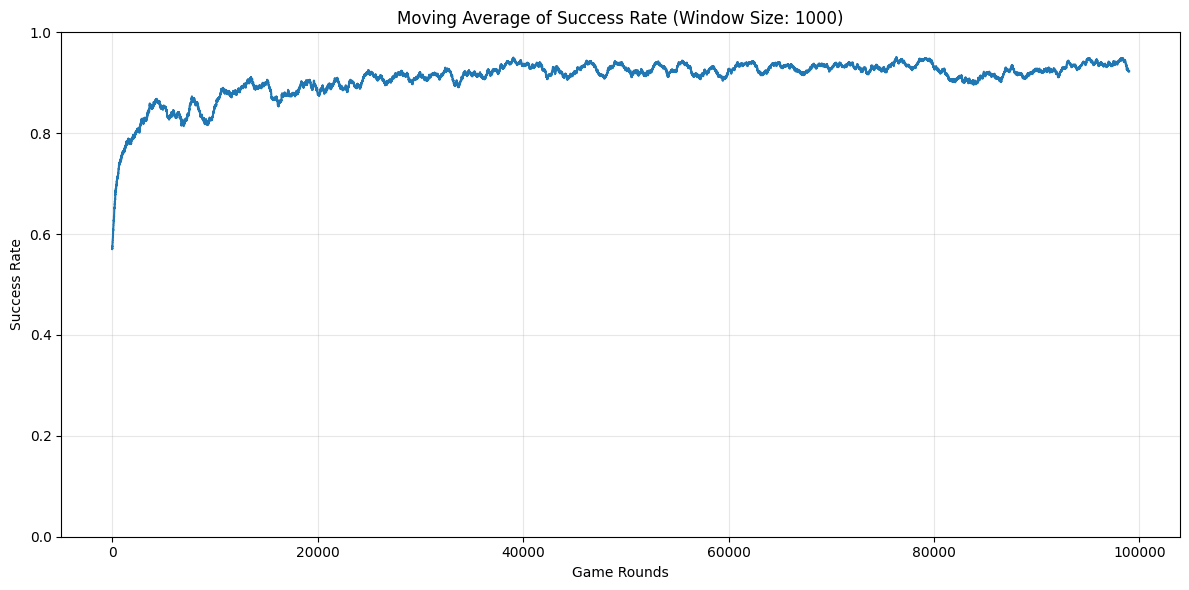

In [35]:
plot_moving_average(game7, window_size=100000*0.01)

In [40]:
def interpretation(game, feature='digit'):
    DIGITS = range(10)
    COLORS = ["red", "green", "blue"]
    SIZES = [0, 1, 2]

    if feature == 'digit':
        feature_values = list(DIGITS)
    elif feature == 'color':
        feature_values = COLORS
    else:
        feature_values = SIZES

    payoffs = [x["p"] for x in game.stats]
    answer_labels = [labels[s["pics"][s["t"]]] for s in game.stats]

    # Get indices of successful trials
    successful_indices = [i for i, success in enumerate(payoffs) if success]
    
    # Extract and process messages
    messages = [F.softmax(s["m"], dim=0) for s in game.stats]
    messages = torch.stack(messages).detach().numpy()
    
    # Filter for successful trials only
    successful_labels = np.array(answer_labels)[successful_indices]
    successful_messages = messages[successful_indices]
    
    # Map feature to index in label tuple
    feature_index = {'digit': 0, 'color': 1, 'size': 2}[feature]
    message_dim = successful_messages.shape[1]
    
    # Plot for each feature value
    for value in feature_values:
        # Filter messages for this feature value
        value_str = str(value)
        matching_messages = successful_messages[
            [i for i, label in enumerate(successful_labels) if label[feature_index] == value_str]
        ]
        
        if len(matching_messages) == 0:
            print(f"{feature.capitalize()} {value}: No successful trials")
            continue
        
        # Calculate average activation per message dimension
        avg_activations = [matching_messages[:, i].mean() for i in range(message_dim)]
        
        # Plot
        plt.figure(figsize=(10, 4))
        plt.bar(x=range(message_dim), height=avg_activations)
        plt.title(f'Average Message Pattern for {feature.capitalize()} {value}')
        plt.xlabel('Message Dimension')
        plt.ylabel('Average Activation')
        plt.xticks(range(message_dim))
        plt.ylim([0, max(avg_activations) * 1.1])
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

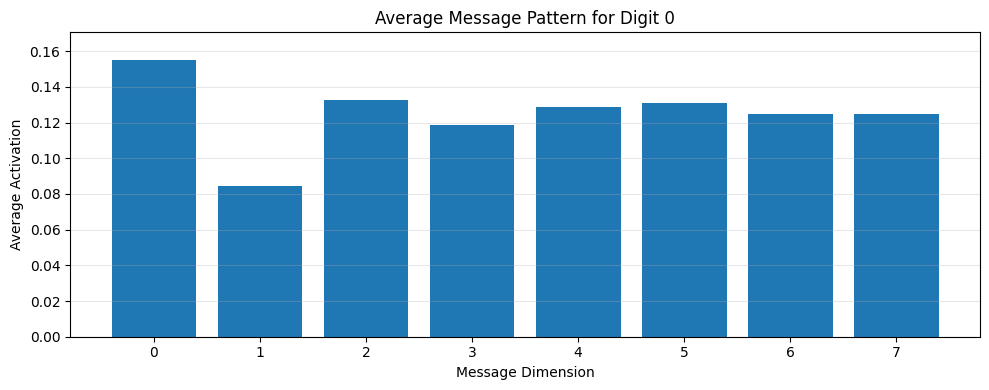

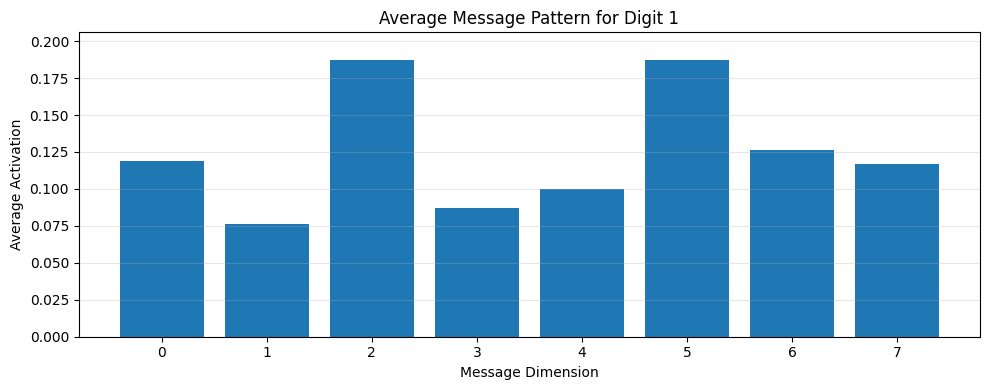

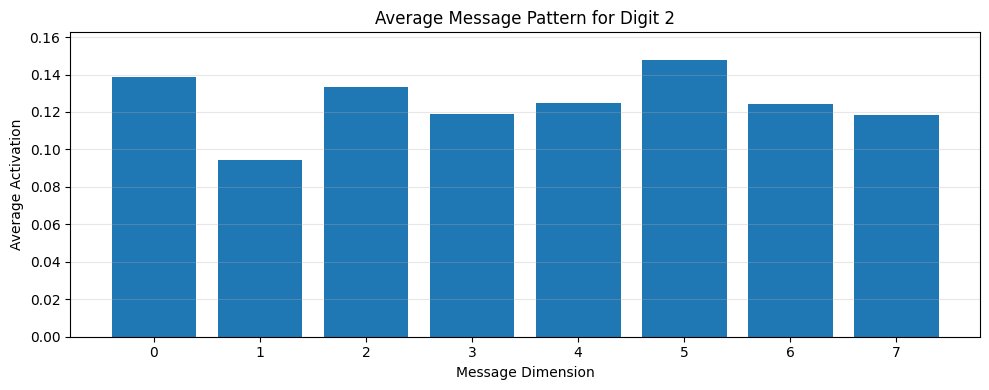

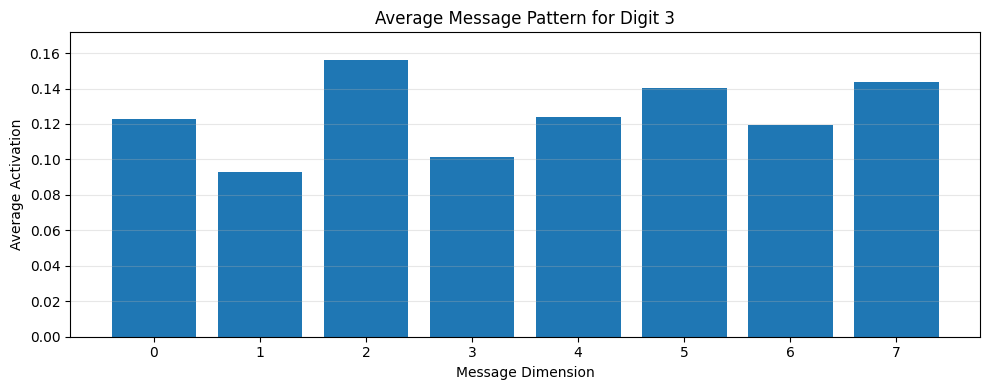

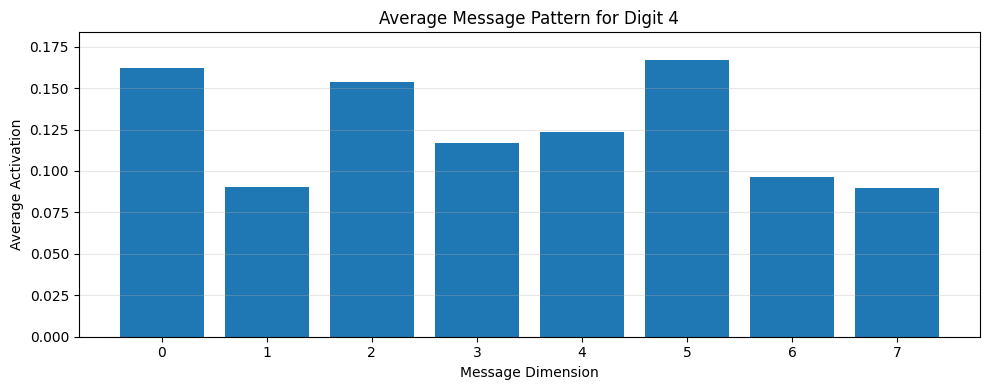

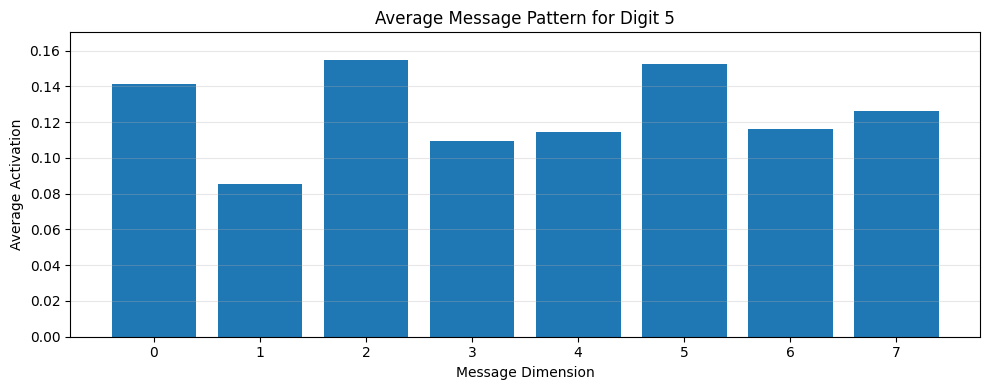

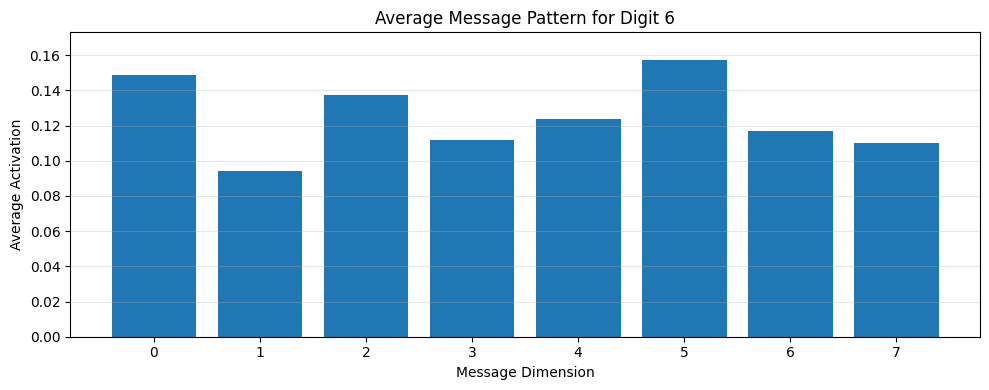

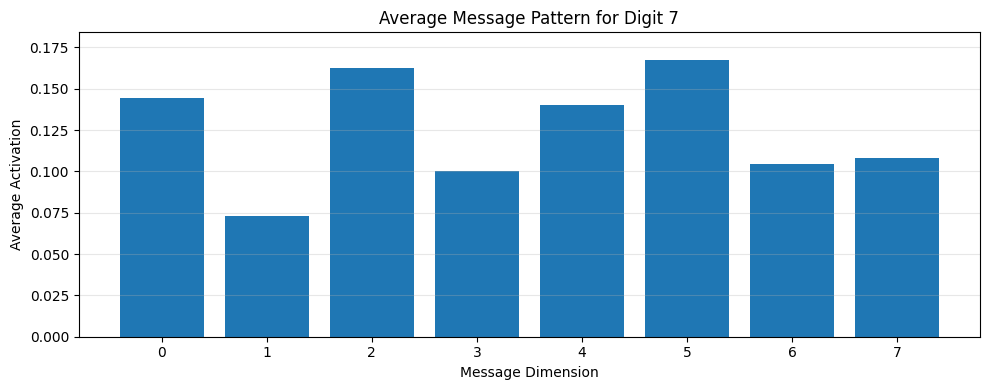

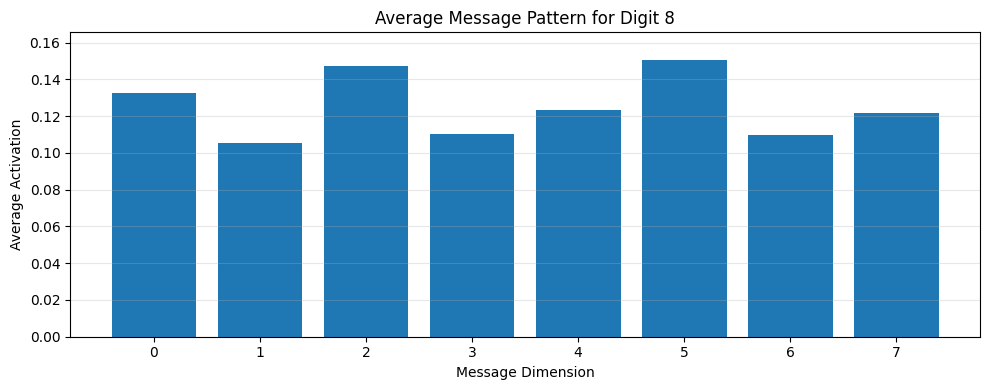

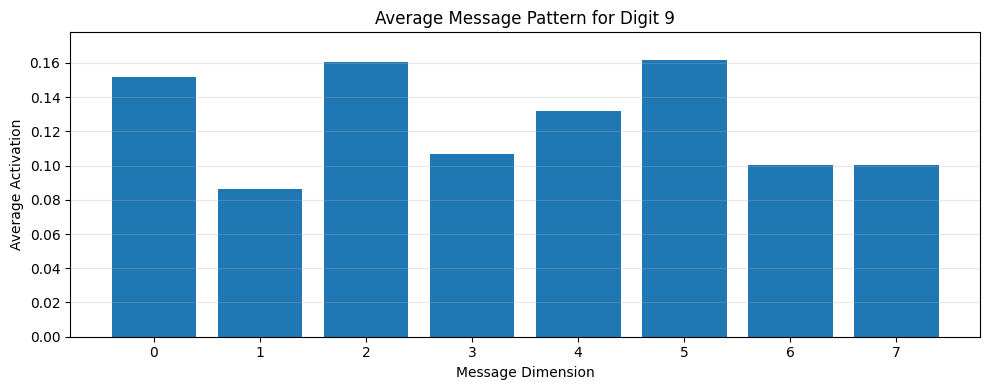

In [41]:
interpretation(game7, feature='digit')

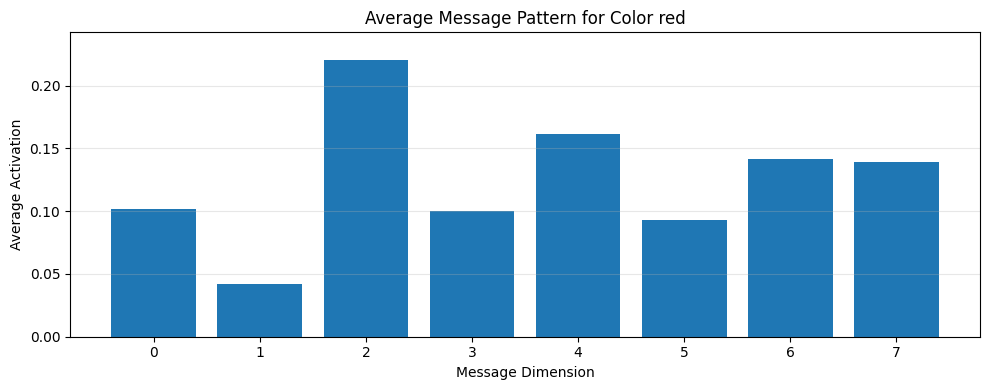

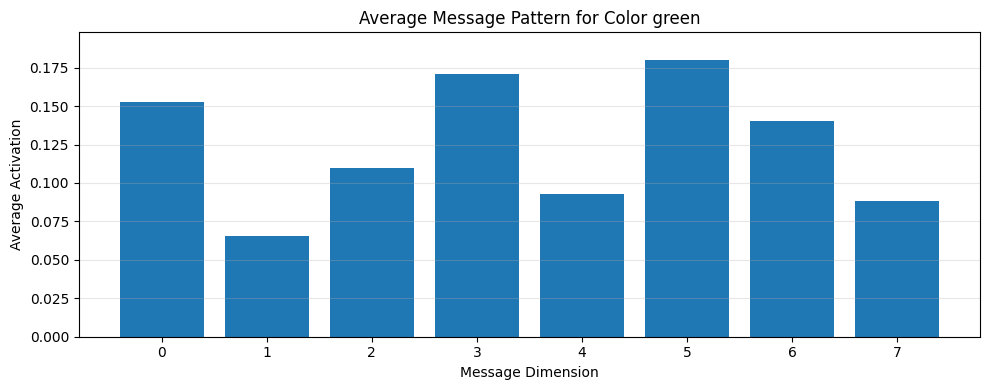

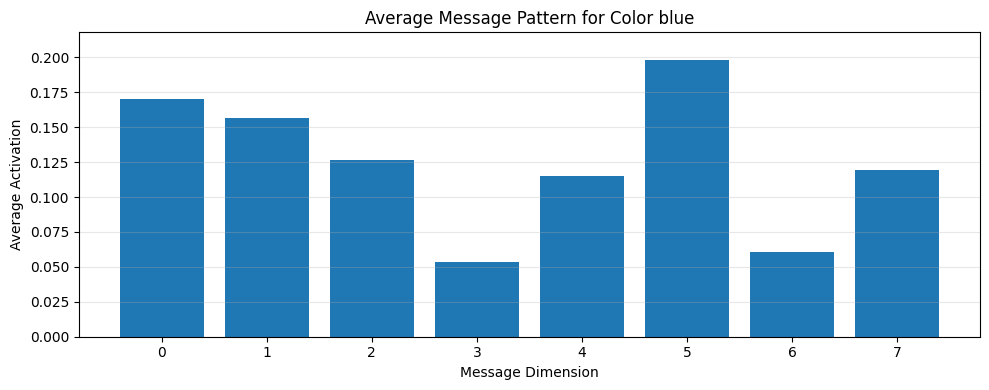

In [42]:
interpretation(game7, feature='color')

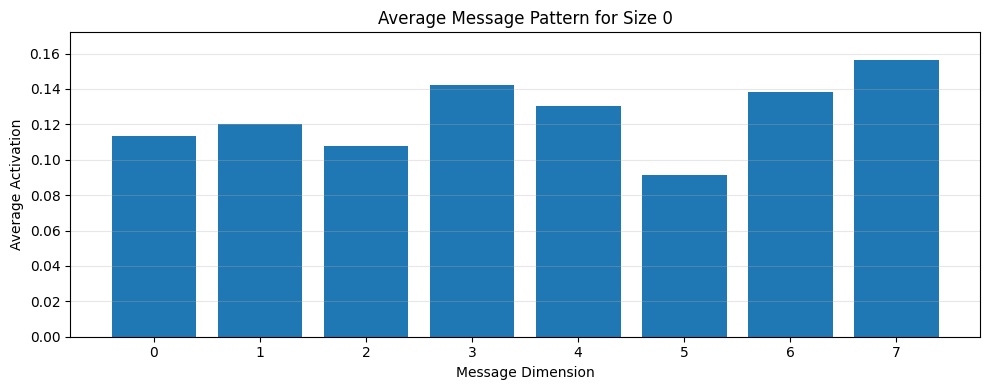

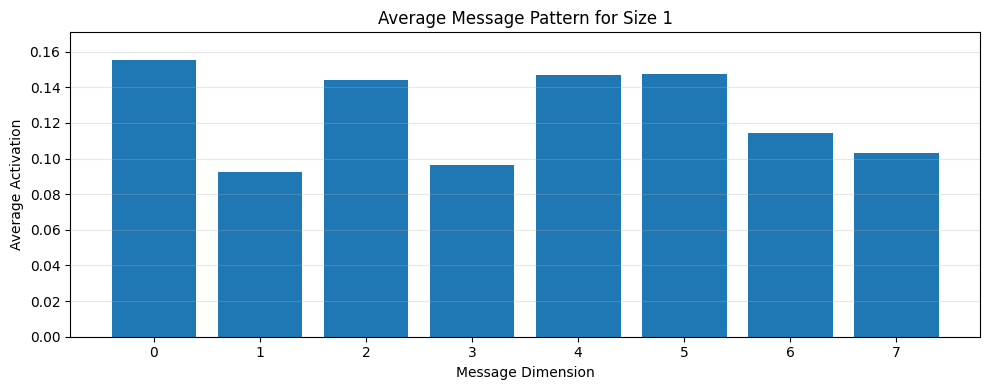

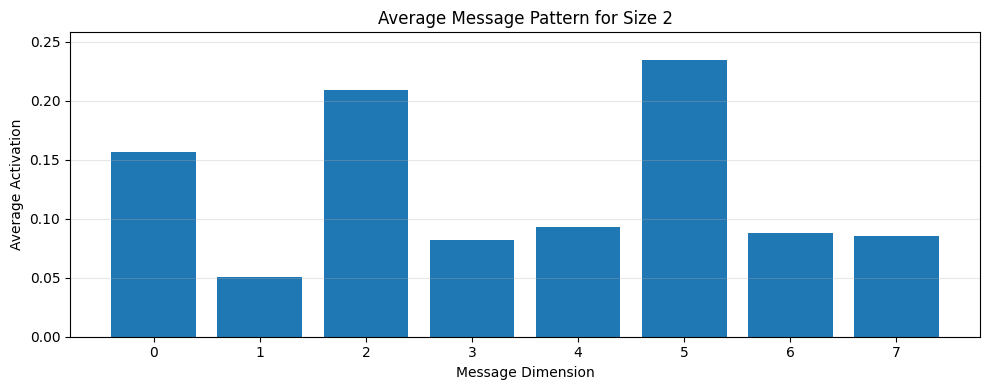

In [43]:
interpretation(game7, feature='size')

Commentaires ici.